In [56]:
import numpy as np
from PIL import Image

def read_images(train_files):
    X = []
    for file_name in train_files:
        thermal_data = np.zeros((128, 160))
        with Image.open(file_name) as img:
            for i in range(img.n_frames):
                img.seek(i)
                frame_data = np.array(img)
                min_val = np.amin(frame_data)
                frame_data -= min_val
                for j in range(img.height):
                    for k in range(img.width):
                        thermal_data[j, k] += frame_data[j, k]
        X.append(thermal_data)

        print(file_name)
        print(thermal_data)
    return X

In [57]:
import os
import glob
import matplotlib as plt

DIR_NAME = 'split_data'

In [58]:
os.chdir(f'../{DIR_NAME}/train')

FileNotFoundError: [Errno 2] No such file or directory: '../split_data/train'

In [78]:
import pickle

HOME = os.getcwd()

X = None
if os.path.exists('inputs.pickle'):
    X = pickle.load(open('inputs.pickle', 'rb'))

else:
    # Full filepaths
    train_files = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                train_files.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X = read_images(train_files)
    pickle.dump(X, open('inputs.pickle', 'wb'))

In [79]:
len(X)/4
(len(train_files)+1)/4

26.0

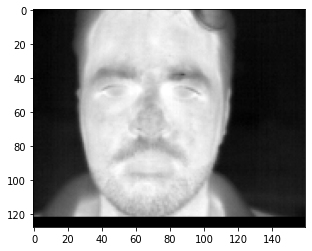

In [120]:
from matplotlib import pyplot

pyplot.imshow(X[83], cmap='gray')

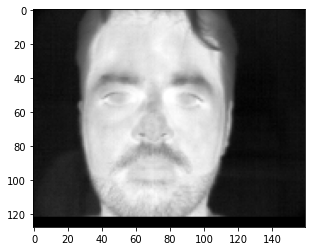

In [118]:
pyplot.imshow(X[84], cmap='gray')